In [1]:
import os 
from glob import glob

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_paths = glob('../dataset/cifar/train/*.png')
sample = train_paths[0]

In [3]:
sample

'../dataset/cifar/train\\0_frog.png'

In [4]:
gfile = tf.io.read_file(sample)
image = tf.io.decode_image(gfile)

In [5]:
image.shape

TensorShape([32, 32, 3])

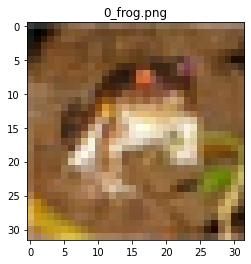

In [6]:
plt.title(os.path.basename(sample))
plt.imshow(image)
plt.show()

# tf.data

In [7]:
def read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    return image

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE)

In [10]:
tf_image = next(iter(dataset))
tf_image.shape

TensorShape([32, 32, 3])

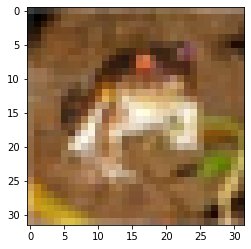

In [11]:
plt.imshow(tf_image)
plt.show()

## Batch로 묶기

In [12]:
batch_size = 4

In [13]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image)
dataset = dataset.batch(batch_size)

In [14]:
tf_images = next(iter(dataset))
tf_images.shape

TensorShape([4, 32, 32, 3])

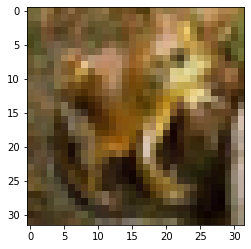

In [15]:
plt.imshow(tf_images[3])
plt.show()

## Shuffle 하기

In [16]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(buffer_size=len(train_paths))
dataset = dataset.repeat()

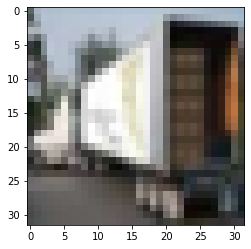

In [17]:
tf_images = next(iter(dataset))
plt.imshow(tf_images[0])
plt.show()

## Label하고 같이 넣기 

In [18]:
def get_label(path):
    return os.path.basename(path).replace('.png', '').split('_')[-1]

In [19]:
sample, get_label(sample)

('../dataset/cifar/train\\0_frog.png', 'frog')

In [20]:
train_labels = [get_label(path) for path in train_paths]
train_labels[:5]

['frog', 'automobile', 'frog', 'frog', 'ship']

In [21]:
class_names = np.unique(train_labels)
class_names

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [22]:
'frog' == class_names

array([False, False, False, False, False, False,  True, False, False,
       False])

In [23]:
onehot_encoding = np.array('frog' == class_names, np.uint8)
onehot_encoding

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [24]:
def onehot_encoding(label):
    return np.array(label == class_names, np.uint8)

In [25]:
def load_data(path, label):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    return image, label

In [26]:
labels = [onehot_encoding(cls_name) for cls_name in train_labels]

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((train_paths, labels))
dataset = dataset.map(load_data, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(buffer_size=len(train_paths))
dataset = dataset.repeat() # 여러 epoch를 돌아가도록 함

In [28]:
batch_image, batch_label = next(iter(dataset))

In [29]:
np.array(batch_label[0])

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8)

C:\Users\jumin\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


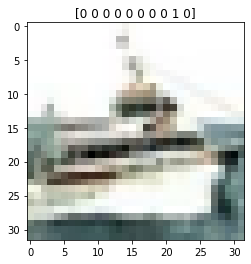

In [30]:
plt.title(np.array(batch_label[0]))
plt.imshow(batch_image[0])
plt.show()

## tensorflow 함수로 label 얻기

In [31]:
sample

'../dataset/cifar/train\\0_frog.png'

In [32]:
fname = tf.strings.split(sample, '_')[-1]
lbl_name = tf.strings.regex_replace(fname, '.png', '')
lbl_name

<tf.Tensor: shape=(), dtype=string, numpy=b'frog'>

In [33]:
class_names

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [34]:
lbl_name == class_names

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([False, False, False, False, False, False,  True, False, False,
       False])>

In [35]:
onehot = tf.cast(lbl_name == class_names, tf.uint8)
onehot

<tf.Tensor: shape=(10,), dtype=uint8, numpy=array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)>

In [36]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return onehot

In [37]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    label = get_label(path)
    return image, label

In [38]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(buffer_size=len(train_paths))
dataset = dataset.repeat()

In [39]:
dataset

<RepeatDataset shapes: (<unknown>, (None, 10)), types: (tf.float32, tf.uint8)>

In [40]:
image, label = next(iter(dataset))

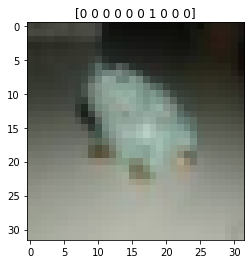

In [41]:
plt.title(np.array(label[0]))
plt.imshow(image[0])
plt.show()